In [1]:
import os, inspect, sys
import datetime, json, gspread
import cPickle as pickle
from oauth2client.client import SignedJwtAssertionCredentials
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [3]:
script_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append(os.path.join(script_dir, os.pardir, os.pardir))

In [4]:
from opengrid.library import config
c = config.Config()

In [5]:
sys.path.append(c.get('tmpo', 'folder'))
import tmpo

try:
    if os.path.exists(c.get('tmpo', 'data')):
        path_to_tmpo_data = c.get('tmpo', 'data')
except:
    path_to_tmpo_data = None

# Class definitions

## Houseprint Singleton

The Houseprint is a Singleton object which contains all metadata for sites, devices and sensors. It can be pickled, saved and passed around

In [6]:
class Houseprint(object):
    def __init__(self, spreadsheet = "Opengrid houseprint (Responses)"):
        
        self.sites = []
        self._parse_sheet(spreadsheet)
        self.timestamp = datetime.datetime.utcnow() #Add a timestamp upon creation
        
    def __repr__(self):
        return """
    Houseprint
    Created on {} (UTC)
    {} sites
    {} devices
    {} sensors
    """.format(self.timestamp,
               len(self.sites),
               sum([len(site.devices) for site in self.sites]),
               sum([len(site.sensors) for site in self.sites])
              )
    
    def _parse_sheet(self, spreadsheet):

        print 'Opening connection to Houseprint sheet'
        #fetch credentials
        gjson = c.get('houseprint','json')
        json_key = json.load(open(gjson))
        scope = ['https://spreadsheets.google.com/feeds']
        credentials = SignedJwtAssertionCredentials(json_key['client_email'], json_key['private_key'], scope)
        
        #authorize and login
        gc = gspread.authorize(credentials)
        gc.login()
        
        #open sheets
        print "Opening spreadsheets"
        sheet = gc.open(spreadsheet)
        sites_sheet = sheet.worksheet('Accounts')
        devices_sheet = sheet.worksheet('Devices')
        sensors_sheet = sheet.worksheet('Sensors')
        
        print 'Parsing spreadsheets'
        self._parse_sites(sites_sheet)
        self._parse_devices(devices_sheet)
        self._parse_sensors(sensors_sheet)
        
        print 'Houseprint parsing complete'
        
    def _parse_sites(self,sheet):
        
        records = sheet.get_all_records()
        
        for r in records:
            if r['Key'] == '': continue
            new_site = Site(hp = self,
                            key = r['Key'],
                           size = r['House size'],
                           inhabitants = r['Number of inhabitants'],
                           postcode = r['postcode'],
                           construction_year = r['construction year'],
                           k_level = r['K-level'],
                           e_level = r['E-level'],
                           epc_cert = r['EPC certificate'])
            self.sites.append(new_site)
            
        print '{} Sites created'.format(len(self.sites))
        
    def _parse_devices(self,sheet):
        
        records = sheet.get_all_records()
                        
        for r in records:
            if r['Key'] == '': continue  
            
            #find parent site and check if it exists
            site = self.find_site(r['Parent site'])
            if site is None:
                raise ValueError('Device {} was given an invalid site key {}'.format(r['Key'], r['Parent site']))
                
            #create a new device according to its manufacturer    
            if r['manufacturer'] == 'Flukso':
                new_device = Fluksometer(site = site, key = r['Key'])
            else:
                raise NotImplementedError('Devices from {} are not supported'.format(r['manufacturer']))
                
            #add new device to parent site
            site.devices.append(new_device)
            
        print '{} Devices created'.format(sum([len(site.devices) for site in self.sites]))
        
    def _parse_sensors(self,sheet):
        
        records = sheet.get_all_records()
        
        for r in records:
            if r['Sensor_id'] == '': continue
            
            #find parent. If a parent device is specified, us that, otherwise use a parent site directly
            if r['parent device'] != '':
                device = self.find_device(r['parent device'])
                if device is None:
                    raise ValueError('Sensor {} was given an invalid device key {}. Leave the device field empty if you want to add a sensor without a device'.format(r['Sensor_id'], r['parent device']))
            else:
                site = self.find_site(r['parent site'])
                if site is None:
                    raise ValueError('Sensor {} was given an invalid site key {}'.format(r['Sensor_id'],r['parent site']))

            #create new sensor according to its manufacturer
            if r['manufacturer'] == 'Flukso':
                new_sensor = Fluksosensor(device = device,
                                         key = r['Sensor_id'],
                                         token = r['token'],
                                         type = r['sensor type'],
                                         description = r['name by user'],
                                         system = r['system'],
                                         quantity = r['quantity'],
                                         unit = r['unit'],
                                         direction = r['direction'],
                                         tariff = r['tariff'])
            else:
                raise NotImplementedError('Sensors from {} are not supported'.format(r['manufacturer']))

            #add sensor to device AND site
            if new_sensor.device is not None:
                new_sensor.device.sensors.append(new_sensor)
            new_sensor.site.sensors.append(new_sensor)
        
        print '{} sensors created'.format(sum([len(site.sensors) for site in self.sites]))
        
    def get_sensors(self, sensortype = None):
        """
            Return a list with all sensors
            
            Parameters
            ----------
            sensortype: gas, water, electricity: optional
        """
        res = []
        for site in self.sites:
            for sensor in site.get_sensors(sensortype = sensortype):
                res.append(sensor)
        return res
        
    def get_devices(self):
        """
            Return a list with all devices
        """
        res = []
        for site in self.sites:
            for device in site.devices:
                res.append(device)
        return res
    
    def find_site(self, key):
        '''
            Parameters
            ----------
            key: string
            
            Returns
            -------
            Site
        '''
        for site in self.sites:
            if site.key == key:
                return site
        return None
    
    def find_device(self, key):
        '''
            Parameters
            ----------
            key: string
            
            Returns
            -------
            Device
        '''
        for device in self.get_devices():
            if device.key == key:
                return device
        return None
    
    def find_sensor(self, key):
        '''
            Parameters
            ----------
            key: string
            
            Returns
            -------
            Sensor
        '''
        for sensor in self.get_sensors():
            if sensor.key == key:
                return sensor
        return None
    
    def save(self, filename):
        """
        Pickle the houseprint object
        
        Parameters
        ----------
        * filename : str
            Filename, if relative path or just filename, it is appended to the
            current working directory
        
        """
        if hasattr(self,'_tmpos'):
            #temporarily delete tmpo session
            tmpos_tmp = self._tmpos
            self._tmpos = None

        abspath = os.path.join(os.getcwd(), filename)
        f=file(abspath, 'w')
        pickle.dump(self, f)
        f.close()
        
        print("Saved houseprint to {}".format(abspath))
        
        if hasattr(self,'_tmpos'):
            #restore tmpo session
            self._tmpos = tmpos_tmp
        
    def init_tmpo(self, tmpos=None):
        """
            Fluksosensors need a tmpo session to obtain data.
            It is overkill to have each fluksosensor make its own session, syncing would take too long and be overly redundant.
            Passing a tmpo session to the get_data function is also bad form because we might add new types of sensors that don't use tmpo in the future.
            This is why the session is initialised here.
            
            A tmpo session as parameter is optional.
            If no session is passed, a new one will be created using the location in the config file.
        """
        
        if tmpos is not None:
            self._tmpos = tmpos
        else:
            self._tmpos = tmpo.Session(path_to_tmpo_data)
            
    def get_tmpos(self):
        """
            Returns
            -------
            TMPO session
        """
        if hasattr(self,'_tmpos'):
            return self._tmpos
        else:
            raise RuntimeError('No TMPO session was set, use the init_tmpo method to add or create a TMPO Session')
            
    def sync_tmpos(self):
        """
            Add all Fluksosensors to the TMPO session and sync
        """
        tmpos = self.get_tmpos()
        fluksosensors = [sensor for sensor in self.get_sensors() if isinstance(sensor,Fluksosensor)]
        
        for sensor in fluksosensors:
            tmpos.add(sensor.key, sensor.token)
            
        tmpos.sync()
        
    def get_data(self, sensortype = None, head = None, tail = None):
        """
            Return a Pandas Dataframe with joined data for all sensors in the houseprint
            
            Parameters
            ----------
            sensortype: gas, water, electricity: optional
            head, tail: timestamps
        """
        sensors = self.get_sensors(sensortype)
        series = [sensor.get_data(head=head,tail=tail) for sensor in sensors]
        return pd.concat(series, axis=1)

In [7]:
def load_houseprint_from_file(filename):
    """Return a static (=anonymous) houseprint object"""
    
    f = open(filename, 'r')    
    hp = pickle.load(f)
    f.close()
    return hp

## Site

A Site is a physical entity (a house, appartment, school, or other building). It may contain multiple devices and sensors.

The Site contains most of the metadata, eg. the number of inhabitants, the size of the building, the location etc.

In [8]:
class Site(object):
    def __init__(self, hp, key, size, inhabitants, postcode, construction_year, k_level, e_level, epc_cert):
        self.hp = hp #backref to parent
        self.key = key
        self.size = size
        self.inhabitants = inhabitants
        self.postcode = postcode
        self.construction_year = construction_year
        self.k_level = k_level
        self.e_level = e_level
        self.epc_cert = epc_cert
        
        self.devices = []
        self.sensors = []
        
    def __repr__(self):
        return """
    Site
    Key: {}
    {} devices
    {} sensors
    """.format(self.key,
               len(self.devices),
               len(self.sensors)
              )
        
    def get_sensors(self, sensortype = None):
        """
            Return a list with all sensors
            
            Parameters
            ----------
            sensortype: gas, water, electricity: optional
        """
        return [sensor for sensor in self.sensors if sensor.type == sensortype or sensortype is None]
    
    def get_data(self, sensortype = None, head = None, tail = None):
        """
            Return a Pandas Dataframe with joined data for all sensors in this Site
            
            Parameters
            ----------
            sensortype: gas, water, electricity: optional
            head, tail: timestamps
        """
        sensors = self.get_sensors(sensortype)
        series = [sensor.get_data(head=head,tail=tail) for sensor in sensors]
        return pd.concat(series, axis=1)

## Device

A Device is an entity that can contain multiple sensors.
The generic Device class can be inherited by a specific device class, eg. Fluksometer

In [9]:
class Device(object):
    def __init__(self, key, site):
        self.key = key
        self.site = site
        self.sensors = []
        
    def __repr__(self):
        return """
    {}
    Key: {}
    {} sensors
    """.format(self.__class__.__name__,
               self.key,
               len(self.sensors)
              )
        
    def get_sensors(self, sensortype = None):
        """
            Return a list with all sensors
            
            Parameters
            ----------
            sensortype: gas, water, electricity: optional
        """
        return [sensor for sensor in self.sensors if sensor.type == sensortype or sensortype is None]
    
    def get_data(self, sensortype = None, head = None, tail = None):
        """
            Return a Pandas Dataframe with the joined data for all sensors in this device
            
            Parameters
            ----------
            sensortype: gas, water, electricity: optional
            head, tail: timestamps indicating start and end
        """
        
        sensors = self.get_sensors(sensortype)
        series = [sensor.get_data(head=head,tail=tail) for sensor in sensors]
        return pd.concat(series, axis=1)

In [10]:
class Fluksometer(Device):
    def __init__(self, site, key, mastertoken = None):
        
        #invoke init method of generic Device
        super(Fluksometer, self).__init__(key, site)
        
        self.mastertoken = mastertoken

## Sensor

A sensor generates a single data stream. It can have a parent device, but the possibility is also left open for a sensor to stand alone in a site.
It is an abstract class definition which has to be overridden (by eg. a Fluksosensor).

This class contains all metadata concerning the function and type of the sensor (eg. electricity - solar, ...)

In [11]:
class Sensor(object):
    def __init__(self, key, device, site, type, description, system, quantity, unit, direction, tariff):
        self.key = key
        self.device = device
        self.site = site
        self.type = type
        self.description = description
        self.system = system
        self.quantity = quantity
        self.unit = unit
        self.direction = direction
        self.tariff = tariff
        
    def __repr__(self):
        return """
    {}
    Key: {}
    Type: {}
    """.format(self.__class__.__name__,
               self.key,
               self.type
              )
        
    def get_data(self, head = None, tail = None):
        """
            Return a Pandas Series with measurement data
            
            Parameters
            ----------
            head, tail: timestamps for the begin and end of the interval
            
            Notes
            -----
            This is an abstract method, because each type of sensor has a different way of fetching the data.
        """
        
        raise NotImplementedError("Subclass must implement abstract method")

In [12]:
class Fluksosensor(Sensor):
    def __init__(self, key, token, device, type, description, system, quantity, unit, direction, tariff):
        
        #invoke init method of abstract Sensor
        super(Fluksosensor, self).__init__(key = key,
                                           device = device,
                                           site = device.site,
                                           type = type,
                                           description = description,
                                           system = system,
                                           quantity = quantity,
                                          unit = unit,
                                          direction = direction,
                                          tariff = tariff)
        
        if token != '':
            self.token = token
        else:
            self.token = parent.mastertoken
        
    # @Override :-D    
    def get_data(self, head = None, tail = None):
        '''
            Connect to tmpo and fetch a data series
            
            Parameters
            ----------
            head, tail: optional timestamps
        '''

        tmpos = self.site.hp.get_tmpos()
        
        if head is None:
            head = 0
        if tail is None:
            tail = tmpo.EPOCHS_MAX
        
        data = tmpos.series(sid = self.key,
                           head = head,
                           tail = tail)
        
        return data

#Test

##Houseprint

In [13]:
hp = Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
22 Sites created
22 Devices created
72 sensors created
Houseprint parsing complete


In [14]:
hp


    Houseprint
    Created on 2015-06-20 19:04:41.950243 (UTC)
    22 sites
    22 devices
    72 sensors
    

In [15]:
hp.sites

[
     Site
     Key: 1
     1 devices
     6 sensors
     , 
     Site
     Key: 2
     1 devices
     6 sensors
     , 
     Site
     Key: 3
     1 devices
     1 sensors
     , 
     Site
     Key: 4
     1 devices
     4 sensors
     , 
     Site
     Key: 5
     1 devices
     1 sensors
     , 
     Site
     Key: 6
     1 devices
     1 sensors
     , 
     Site
     Key: 7
     1 devices
     5 sensors
     , 
     Site
     Key: 8
     1 devices
     4 sensors
     , 
     Site
     Key: 9
     1 devices
     4 sensors
     , 
     Site
     Key: 10
     1 devices
     3 sensors
     , 
     Site
     Key: 11
     1 devices
     2 sensors
     , 
     Site
     Key: 12
     1 devices
     1 sensors
     , 
     Site
     Key: 13
     1 devices
     2 sensors
     , 
     Site
     Key: 14
     1 devices
     1 sensors
     , 
     Site
     Key: 15
     1 devices
     6 sensors
     , 
     Site
     Key: 16
     1 devices
     5 sensors
     , 
     Site
     Key: 17
     1 d

In [16]:
hp.get_devices()

[
     Fluksometer
     Key: FL03001552
     6 sensors
     , 
     Fluksometer
     Key: FL03001561
     6 sensors
     , 
     Fluksometer
     Key: FL02000449
     1 sensors
     , 
     Fluksometer
     Key: FL03001566
     4 sensors
     , 
     Fluksometer
     Key: FL03001578
     1 sensors
     , 
     Fluksometer
     Key: FL03001577
     1 sensors
     , 
     Fluksometer
     Key: FL03001573
     5 sensors
     , 
     Fluksometer
     Key: FL03001553
     4 sensors
     , 
     Fluksometer
     Key: FL03001556
     4 sensors
     , 
     Fluksometer
     Key: FL03001550
     3 sensors
     , 
     Fluksometer
     Key: FL02000628
     2 sensors
     , 
     Fluksometer
     Key: FL03001557
     1 sensors
     , 
     Fluksometer
     Key: FL03001560
     2 sensors
     , 
     Fluksometer
     Key: FL03001549
     1 sensors
     , 
     Fluksometer
     Key: FL03001570
     6 sensors
     , 
     Fluksometer
     Key: FL03001525
     5 sensors
     , 
     Fluksometer
     

In [17]:
hp.get_sensors('water')

[
     Fluksosensor
     Key: 661684d35cd07dfc657a60b844860785
     Type: water
     , 
     Fluksosensor
     Key: b28509eb97137e723995838c393d49df
     Type: water
     , 
     Fluksosensor
     Key: 36dac700f81c6be9ca233e6534182ed4
     Type: water
     , 
     Fluksosensor
     Key: 2923b75daf93e539e37ce5177c0008c5
     Type: water
     , 
     Fluksosensor
     Key: a8054ca7865584e69a7c946aeea1e13c
     Type: water
     , 
     Fluksosensor
     Key: 4e63e6b6b5bdb137658d84a861593e5c
     Type: water
     , 
     Fluksosensor
     Key: 1a5c55ec176d24483572aca420ac59b5
     Type: water
     , 
     Fluksosensor
     Key: c57f45b21e2ec21ab427f172478e1ca4
     Type: water
     , 
     Fluksosensor
     Key: a926bc966f178fc5d507a569a5bfc3d7
     Type: water
     , 
     Fluksosensor
     Key: a519ce042e8748570d3a91cfca16a747
     Type: water
     ]

A Houseprint object can be saved as a pickle. It loses its tmpo session however (connections cannot be pickled)

In [18]:
hp.save('new_houseprint.pkl')

Saved houseprint to /Users/Jan/opengrid/scripts/new_houseprint.pkl


In [19]:
hp = load_houseprint_from_file('new_houseprint.pkl')

###TMPO

The houseprint, sites, devices and sensors all have a get_data method. In order to get these working for the fluksosensors, the houseprint needs a tmpo session

In [20]:
hp.init_tmpo()

In [21]:
hp.sync_tmpos()

/Library/Python/2.7/site-packages/requests/packages/urllib3/connection.py:251: SecurityWarning: Certificate has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SecurityWarning
/Library/Python/2.7/site-packages/requests/packages/urllib3/connection.py:251: SecurityWarning: Certificate has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for details.)
  SecurityWarning
/Library/Python/2.7/site-packages/requests/packages/urllib3/connection.py:251: SecurityWarning: Certificate has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/shazow/urllib3/issues/497 for detai

###Lookup sites, devices, sensors

In [22]:
hp.find_site(1)


    Site
    Key: 1
    1 devices
    6 sensors
    

In [23]:
hp.find_device('FL03001552')


    Fluksometer
    Key: FL03001552
    6 sensors
    

In [24]:
hp.find_sensor('53b1eb0479c83dee927fff10b0cb0fe6')


    Fluksosensor
    Key: 53b1eb0479c83dee927fff10b0cb0fe6
    Type: electricity
    

###Get Data

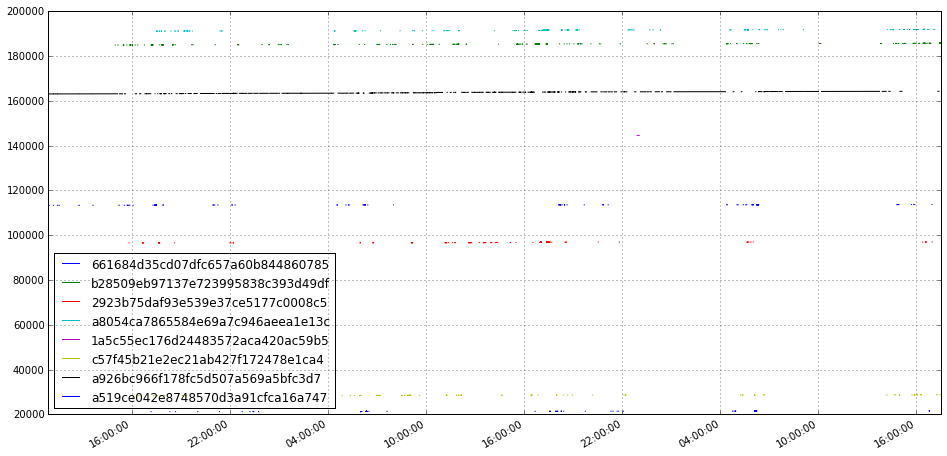

In [25]:
head = pd.Timestamp('20150617')
tail = pd.Timestamp('20150618')
hp.get_data(sensortype='water', head=head,tail=tail).plot()

##Site

In [26]:
site = hp.find_site(1)
site


    Site
    Key: 1
    1 devices
    6 sensors
    

In [27]:
print site.size
print site.inhabitants
print site.postcode
print site.construction_year
print site.k_level
print site.e_level
print site.epc_cert

160
5

1913


263


In [28]:
site.devices

[
     Fluksometer
     Key: FL03001552
     6 sensors
     ]

In [29]:
site.get_sensors('electricity')

[
     Fluksosensor
     Key: 53b1eb0479c83dee927fff10b0cb0fe6
     Type: electricity
     , 
     Fluksosensor
     Key: 7fae5d2f0354bd3f3681881918a253c8
     Type: electricity
     , 
     Fluksosensor
     Key: e8fa1a454e137aa36c1adfd9de94406b
     Type: electricity
     ]

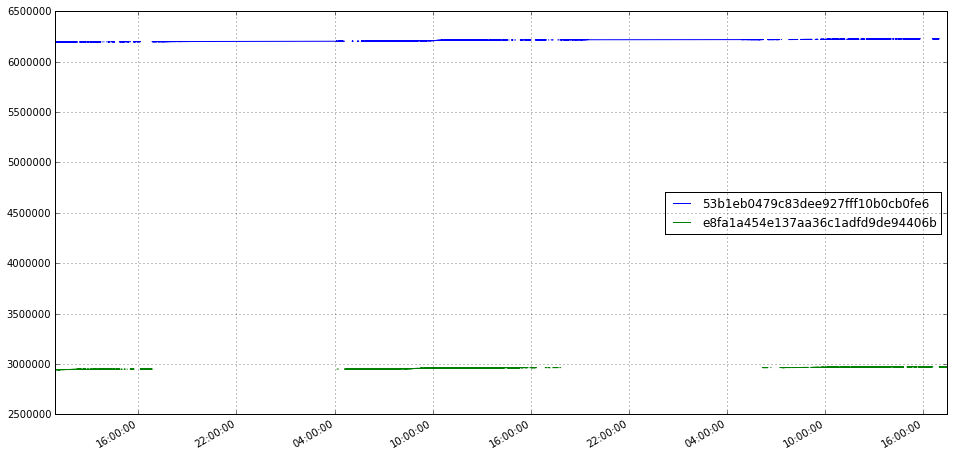

In [30]:
head = pd.Timestamp('20150617')
tail = pd.Timestamp('20150618')
site.get_data(sensortype='electricity', head=head,tail=tail).plot()

##Device

In [31]:
device = hp.find_device('FL03001552')
device


    Fluksometer
    Key: FL03001552
    6 sensors
    

In [32]:
device.key

'FL03001552'

In [33]:
device.get_sensors('gas')

[
     Fluksosensor
     Key: a6028457292f1866b468b63adcc82ee3
     Type: gas
     , 
     Fluksosensor
     Key: 29ba25498c657eda0cdd34bf22d3f9e4
     Type: gas
     ]

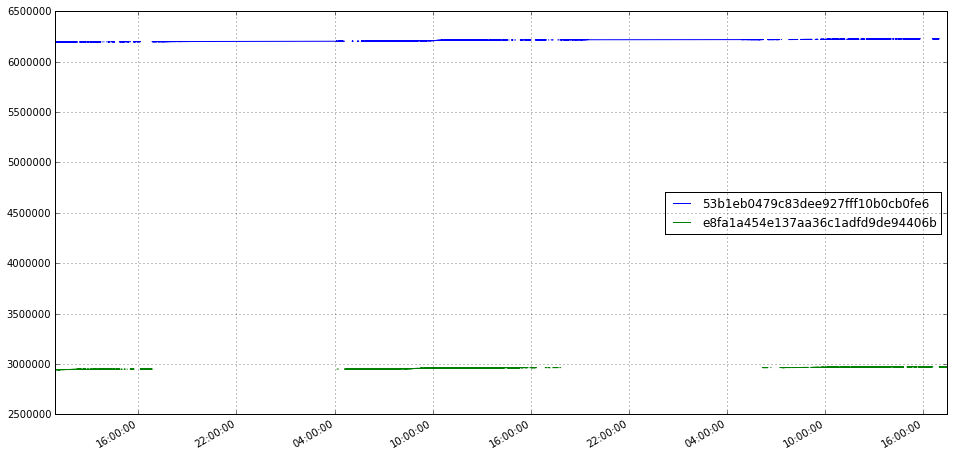

In [34]:
head = pd.Timestamp('20150617')
tail = pd.Timestamp('20150618')
device.get_data(sensortype='electricity', head=head,tail=tail).plot()

##Sensor

In [35]:
sensor = hp.find_sensor('53b1eb0479c83dee927fff10b0cb0fe6')
sensor


    Fluksosensor
    Key: 53b1eb0479c83dee927fff10b0cb0fe6
    Type: electricity
    

In [36]:
sensor.key

'53b1eb0479c83dee927fff10b0cb0fe6'

In [37]:
sensor.type

'electricity'

In [38]:
sensor.description

'Main'

In [39]:
sensor.system

'grid'

In [40]:
sensor.unit

'Wh'

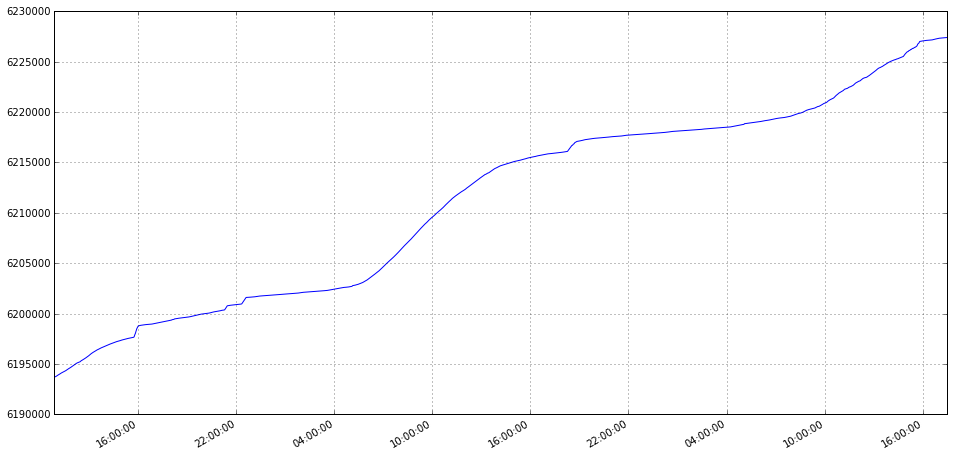

In [41]:
head = pd.Timestamp('20150617')
tail = pd.Timestamp('20150618')
sensor.get_data(head,tail).plot()